In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torchvision
from sklearn.metrics import confusion_matrix  
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import VisionDataset
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import os.path
import sys
from torch.backends import cudnn
import numpy as np
import matplotlib.pyplot as plt

from datasets import Cityscapes
from clients import *
from servers import *
from models import *
from utils import *

In [3]:
#DEVICE = 'cuda' # 'cuda' or 'cpu'
DEVICE = 'cuda'
NUM_CLASSES = 19 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 16     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 5*1e-3           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default -5

NUM_EPOCHS = 25      # 20/30 Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       #20 How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [4]:
#transformations
size = (256, 512) #512,1024
scales=(0.25, 2.)
cropsize=(512, 1024)
eval_crop=(1024, 1024)
eval_scales=(0.5, 0.75, 1.0, 1.25, 1.5, 1.75)
test_transformations = [RandomResizedCrop(eval_scales, eval_crop)]
train_transformations = [RandomResizedCrop(scales,cropsize),RandomHorizontalFlip(),ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4)]
test_transformations = Compose(test_transformations)
train_transformations = Compose(train_transformations)

In [5]:

clients = []
datasets = []
with open("/content/drive/MyDrive/data/data/Cityscapes/train_B_II.txt") as lines:
  curr_id = 0
  paths = []
  for line in lines:
    id_client,path = line.split(" ")
    if curr_id == int(id_client):
      paths.append(path)
    else:
      print(f"finished Client ID:[{curr_id}]: len: {len(paths)}")
      dataset = DatasetClient("/content/drive/MyDrive/data/data/Cityscapes",paths,train_transformations)
      datasets.append(dataset)
      client = Client(curr_id,dataset)
      clients.append(client)

      paths = []
      paths.append(path)
      curr_id = int(id_client)  

  dataset = DatasetClient("/content/drive/MyDrive/data/data/Cityscapes",paths,train_transformations)
  datasets.append(dataset)
  client = Client(curr_id,dataset)
  clients.append(client)

#print(len(clients), f"last: {curr_id}")

finished Client ID:[0]: len: 20


Downloading: "https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth" to /root/.cache/torch/hub/checkpoints/backbone_v2.pth


  0%|          | 0.00/8.34M [00:00<?, ?B/s]

finished Client ID:[1]: len: 20
finished Client ID:[2]: len: 20
finished Client ID:[3]: len: 8
finished Client ID:[4]: len: 19
finished Client ID:[5]: len: 20
finished Client ID:[6]: len: 13
finished Client ID:[7]: len: 20
finished Client ID:[8]: len: 1
finished Client ID:[9]: len: 20
finished Client ID:[10]: len: 13
finished Client ID:[11]: len: 20
finished Client ID:[12]: len: 20
finished Client ID:[13]: len: 8
finished Client ID:[14]: len: 14
finished Client ID:[15]: len: 19
finished Client ID:[16]: len: 20
finished Client ID:[17]: len: 10
finished Client ID:[18]: len: 13
finished Client ID:[19]: len: 20
finished Client ID:[20]: len: 20
finished Client ID:[21]: len: 15
finished Client ID:[22]: len: 20
finished Client ID:[23]: len: 3
finished Client ID:[24]: len: 20
finished Client ID:[25]: len: 5
finished Client ID:[26]: len: 20
finished Client ID:[27]: len: 4
finished Client ID:[28]: len: 20
finished Client ID:[29]: len: 14
finished Client ID:[30]: len: 14
finished Client ID:[31]: 

In [6]:
test_dataset_B = Cityscapes('/content/drive/MyDrive/data/data/Cityscapes',transform=None,split='val')
test_dataset_A = Cityscapes('/content/drive/MyDrive/data/data/Cityscapes',transform=None,split='valA')
train_dataset_A = Cityscapes('/content/drive/MyDrive/data/data/Cityscapes',transform=train_transformations,split='valA')

In [12]:
test_dataloader_B = DataLoader(test_dataset_B, batch_size=1, shuffle=False, num_workers=2,drop_last=True)
test_dataloader_A = DataLoader(test_dataset_A, batch_size=1, shuffle=False, num_workers=2,drop_last=True)
criterion = nn.CrossEntropyLoss(ignore_index=255,reduction='none') 

In [ ]:
model_path = "/content/drive/MyDrive/Results/Step2/LR5e-4_25epochs_16batchsize/dataset_A_0.36test_mIoU/bisenet_best_mIoU_0.0005_tranformation (1).pt"
server = Server(clients, model_path,test_dataloader_B)

server.train() #circa 480 round per 12 ore



In [16]:
LEN = 54
def plotLoss(train,label):
  epochs = np.array([a*10 for a in range(LEN)]).reshape(LEN,1)
  plt.figure()
  #plt.plot(epochs,val,label='val_loss')
  plt.ylim(0,max(train)+1)
  plt.plot(epochs,train,label=label)
  plt.legend()
  plt.show()

def plotmIoU(train,label):
  epochs = np.array([a*10 for a in range(LEN)]).reshape(LEN,1)
  plt.figure()
  #plt.plot(epochs,val,label='val_loss')
  plt.ylim(0,max(train)+0.1)
  plt.plot(epochs,train,label=label)
  plt.legend()
  plt.show()

In [9]:
bisenet_model = BiSeNetV2(n_classes=19,output_aux=True,pretrained=True)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/magna/step5/FDA/DatasetA_I/checkpoints/T1/100checkpoint.pt')
bisenet_model.load_state_dict(checkpoint['model_state_dict'])
  
bisenet_model.to(DEVICE)

mIoU = checkpoint['mIoU_for_rounds']
plotmIoU(mIoU)


In [10]:
def _fast_hist(n_classes, label_true, label_pred):
      mask = (label_true >= 0) & (label_true < n_classes)
      hist = np.bincount(
          n_classes * label_true[mask].astype(int) + label_pred[mask],
          minlength=n_classes ** 2,
      ).reshape(n_classes, n_classes)
      return hist


def compute_mIoU(y_true,y_pred):
  
  y_pred = y_pred.cpu().numpy().flatten()
  y_true = y_true.cpu().numpy().flatten()
 
  hist = _fast_hist(19,y_true,y_pred)
  gt_sum = hist.sum(axis=1)
  mask = (gt_sum != 0)
  diag = np.diag(hist)
  iu = diag / (gt_sum + hist.sum(axis=0) - diag)
  mean_iu = np.mean(iu[mask])
  return mean_iu

In [11]:
from torchvision import ops
from tqdm import tqdm
def mIoU_test_dataset(dataloader):
  net = bisenet_model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  net=net.half()
  running_corrects = 0
  torch.cuda.empty_cache() 
  IoU = 0
  count = 0
  for images, labels in tqdm(dataloader):
    images = images.half().to(DEVICE)
    labels = labels.half().to(DEVICE)
    
    outputs = net(images,test=True,use_test_resize=False)
    preds = outputs.argmax(dim=1)

    loss = criterion(outputs,labels.long())[labels!=255].mean()


   
    IoU += compute_mIoU(labels,preds)
    
    count += 1
    
  print("mIoU = ",IoU/count)
  return IoU/count,loss.item()

In [14]:
mIoU_test_for_epochs = []
loss_test_for_epochs = []
mIoU_train_for_epochs = []
loss_train_for_epochs = []
for i in range(0,540,10):
  print("checkpoint:",i)
  checkpoint = torch.load('/content/drive/MyDrive/magna/step3/checkpoint/long_esp_dataset_B_II_0.005/' +str(i)+'checkpoint.pt')
  bisenet_model.load_state_dict(checkpoint['model_state_dict'])
 
  bisenet_model.to(DEVICE)
  
  mIoU,loss = mIoU_test_dataset(train_dataloader_B)
  mIoU_train_for_epochs.append(mIoU)
  loss_train_for_epochs.append(loss)

print(loss_test_for_epochs)
print(loss_train_for_epochs)
print(mIoU_test_for_epochs)
print(mIoU_train_for_epochs)


checkpoint: 0


100%|██████████| 250/250 [05:04<00:00,  1.22s/it]


mIoU =  0.023141610912084613
checkpoint: 10


100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


mIoU =  0.06875841608253314
checkpoint: 20


100%|██████████| 250/250 [01:24<00:00,  2.97it/s]


mIoU =  0.07005434787784921
checkpoint: 30


100%|██████████| 250/250 [01:24<00:00,  2.97it/s]


mIoU =  0.08191261095274781
checkpoint: 40


100%|██████████| 250/250 [01:22<00:00,  3.02it/s]


mIoU =  0.08692888597323914
checkpoint: 50


  6%|▌         | 14/250 [00:05<01:13,  3.23it/s]<ipython-input-10-4fe007d10cf6>:29: RuntimeWarning: invalid value encountered in true_divide
  iu = diag / (gt_sum + hist.sum(axis=0) - diag)
100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


mIoU =  0.100140189359048
checkpoint: 60


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.11891192777949383
checkpoint: 70


100%|██████████| 250/250 [01:23<00:00,  3.00it/s]


mIoU =  0.13449222512863526
checkpoint: 80


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.14094114112888276
checkpoint: 90


100%|██████████| 250/250 [01:25<00:00,  2.93it/s]


mIoU =  0.1383934323680772
checkpoint: 100


100%|██████████| 250/250 [01:22<00:00,  3.02it/s]


mIoU =  0.13906126782113667
checkpoint: 110


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.1340681991059788
checkpoint: 120


100%|██████████| 250/250 [01:25<00:00,  2.91it/s]


mIoU =  0.13318293133411865
checkpoint: 130


100%|██████████| 250/250 [01:23<00:00,  2.98it/s]


mIoU =  0.1354670333823022
checkpoint: 140


100%|██████████| 250/250 [01:25<00:00,  2.93it/s]


mIoU =  0.11373567227859453
checkpoint: 150


100%|██████████| 250/250 [01:25<00:00,  2.93it/s]


mIoU =  0.14338185846585014
checkpoint: 160


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.14565307981725148
checkpoint: 170


100%|██████████| 250/250 [01:23<00:00,  2.98it/s]


mIoU =  0.13475988090108373
checkpoint: 180


100%|██████████| 250/250 [01:25<00:00,  2.91it/s]


mIoU =  0.1699537031760718
checkpoint: 190


100%|██████████| 250/250 [01:25<00:00,  2.91it/s]


mIoU =  0.1560519845029272
checkpoint: 200


100%|██████████| 250/250 [01:23<00:00,  3.00it/s]


mIoU =  0.15554851252811136
checkpoint: 210


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.16900869426402326
checkpoint: 220


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.1586069684660935
checkpoint: 230


100%|██████████| 250/250 [01:23<00:00,  2.99it/s]


mIoU =  0.17958484583881143
checkpoint: 240


100%|██████████| 250/250 [01:25<00:00,  2.94it/s]


mIoU =  0.14838770931023684
checkpoint: 250


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.15023312357783375
checkpoint: 260


100%|██████████| 250/250 [01:22<00:00,  3.03it/s]


mIoU =  0.1524188954557054
checkpoint: 270


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.15181513967208923
checkpoint: 280


100%|██████████| 250/250 [01:25<00:00,  2.93it/s]


mIoU =  0.16338039974130222
checkpoint: 290


100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


mIoU =  0.14744419413539026
checkpoint: 300


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.1422149075071855
checkpoint: 310


100%|██████████| 250/250 [01:25<00:00,  2.94it/s]


mIoU =  0.17435100555840052
checkpoint: 320


100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


mIoU =  0.16267025472225713
checkpoint: 330


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.17221708050728632
checkpoint: 340


100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


mIoU =  0.17775247413336565
checkpoint: 350


100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


mIoU =  0.17536377630604497
checkpoint: 360


100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


mIoU =  0.17151764708985556
checkpoint: 370


100%|██████████| 250/250 [01:22<00:00,  3.02it/s]


mIoU =  0.1753905617415331
checkpoint: 380


100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


mIoU =  0.16923069451552336
checkpoint: 390


100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


mIoU =  0.1650467506938354
checkpoint: 400


100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


mIoU =  0.17641255337486778
checkpoint: 410


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.15599813043299038
checkpoint: 420


100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


mIoU =  0.18027549045244726
checkpoint: 430


100%|██████████| 250/250 [01:22<00:00,  3.02it/s]


mIoU =  0.19005082448911134
checkpoint: 440


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.1725236701453052
checkpoint: 450


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.1890549787538087
checkpoint: 460


100%|██████████| 250/250 [01:22<00:00,  3.02it/s]


mIoU =  0.19928303890059348
checkpoint: 470


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.17874757676932715
checkpoint: 480


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


mIoU =  0.16239030160707585
checkpoint: 490


100%|██████████| 250/250 [01:22<00:00,  3.02it/s]


mIoU =  0.1503479537834683
checkpoint: 500


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.16944471889462895
checkpoint: 510


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


mIoU =  0.15209746289250808
checkpoint: 520


100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


mIoU =  0.15493071489358248
checkpoint: 530


100%|██████████| 250/250 [01:25<00:00,  2.94it/s]

mIoU =  0.16839089182859576
[3.166015625, 2.283203125, 1.7919921875, 1.556640625, 1.5, 1.4677734375, 1.4345703125, 1.3251953125, 1.3359375, 1.365234375, 1.302734375, 1.375, 1.3193359375, 1.3408203125, 1.4208984375, 1.3095703125, 1.33984375, 1.390625, 1.2509765625, 1.4326171875, 1.3603515625, 1.2705078125, 1.3740234375, 1.197265625, 1.3525390625, 1.2607421875, 1.232421875, 1.2666015625, 1.19140625, 1.337890625, 1.2744140625, 1.18359375, 1.2294921875, 1.154296875, 1.12890625, 1.1259765625, 1.1396484375, 1.2119140625, 1.1875, 1.1845703125, 1.150390625, 1.2373046875, 1.150390625, 1.1220703125, 1.177734375, 1.1962890625, 1.1708984375, 1.16015625, 1.2041015625, 1.2333984375, 1.13671875, 1.265625, 1.208984375, 1.1123046875]
[]
[0.023141610912084613, 0.06875841608253314, 0.07005434787784921, 0.08191261095274781, 0.08692888597323914, 0.100140189359048, 0.11891192777949383, 0.13449222512863526, 0.14094114112888276, 0.1383934323680772, 0.13906126782113667, 0.1340681991059788, 0.13318293133411865,

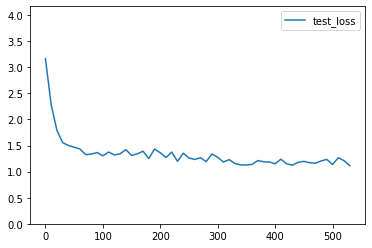

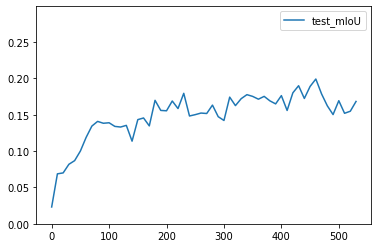

In [17]:
plotLoss(loss_test_for_epochs,'test_loss')
plotmIoU(mIoU_test_for_epochs,'test_mIoU')